In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ID_Quora_Paraphrasing_train.csv')
df = pd.DataFrame(data)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134084 entries, 0 to 134083
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   question_1  134084 non-null  object
 1   question_2  134084 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [5]:
df.head()

,question_1,question_2
0,Apa beberapa teknik yoga yang baik untuk menur...,Apa asana yoga untuk menurunkan berat badan?
1,Bagaimana musik memicu emosi?,Mengapa musik bertanggung jawab untuk memicu e...
2,Apa beberapa contoh bagaimana data dan informa...,Apa perbedaan antara data dan informasi dengan...
3,Haruskah saya menggunakan papan ouija? Apakah ...,Apakah Papan Ouija benar-benar memanggil roh? ...
4,Apa saja hal-hal yang orang awam tahu tetapi j...,Apa yang diketahui oleh jutawan bahwa orang bi...


In [6]:
df['sentence1_length'] = df['question_1'].apply(lambda x: len(x.split()))
df['sentence2_length'] = df['question_2'].apply(lambda x: len(x.split()))

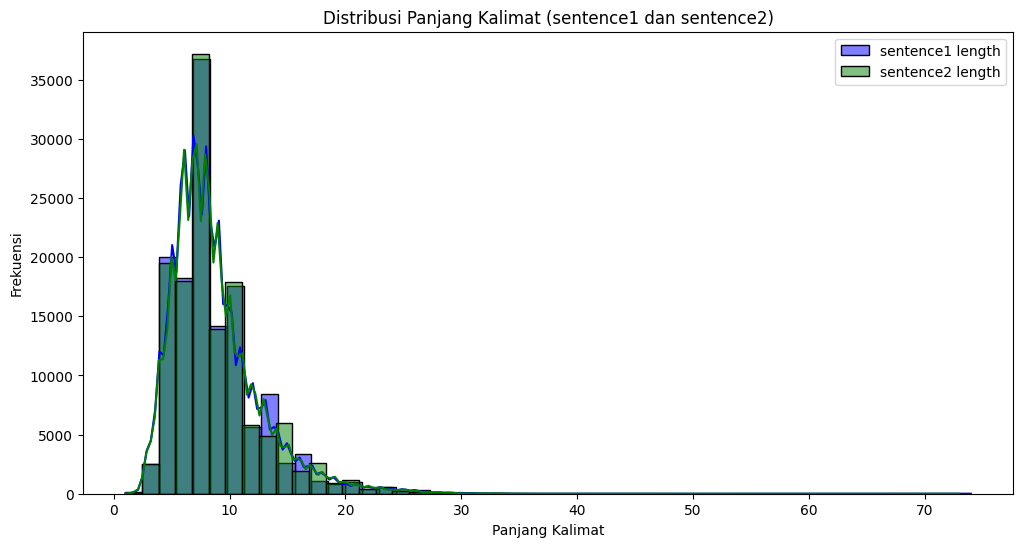

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['sentence1_length'], bins=50, kde=True, color='blue', label='sentence1 length')
sns.histplot(df['sentence2_length'], bins=50, kde=True, color='green', label='sentence2 length')
plt.legend()
plt.title('Distribusi Panjang Kalimat (sentence1 dan sentence2)')
plt.xlabel('Panjang Kalimat')
plt.ylabel('Frekuensi')
plt.show()

In [8]:
X = df['question_1']
y = df['question_2']

In [9]:
X.shape, y.shape

((134084,), (134084,))

In [10]:
X = X[:50000]
y = y[:50000]

In [11]:
X.shape, y.shape

((50000,), (50000,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape
y_train.shape

(40000,)

In [14]:
print("Shapes after split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print("y_train sample:", y_train[:10])  # Sample check

Shapes after split:
X_train: (40000,), y_train: (40000,)
X_test: (10000,), y_test: (10000,)
y_train sample: 39087    Apakah Anda lebih suka anjing atau kucing dan ...
30893    Apakah akan relatif aman untuk bepergian ke Is...
45278    Apa yang Anda pikirkan tentang film Rogue One:...
16398       Apakah mudah untuk belajar cara bermain gitar?
13653    Apa yang harus saya beri nama restoran India b...
13748    Bagaimana Anda bisa memperbaiki masalah prokra...
23965    yang lebih baik, New York City atau Los Angele...
45552    yang merupakan pekerjaan paruh waktu online te...
30219                        adalah homoseksualitas alami?
24079                        Apa itu reflektor jalan biru?
Name: question_2, dtype: object


In [15]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(pd.concat([X_train, y_train]).values)  # Menggabungkan kolom untuk kosakata

In [16]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
y_train_seq = tokenizer.texts_to_sequences(y_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
y_test_seq = tokenizer.texts_to_sequences(y_test)

In [17]:
vocab_size = len(tokenizer.word_index) + 1  # Tambahkan +1 untuk kata yang tidak dikenal
embedding_dim = 100
max_length = max(
    max(len(seq) for seq in X_train_seq), max(len(seq) for seq in y_train_seq)
)  # Panjang maksimum dari semua sequence di data train

In [18]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
y_train_padded = pad_sequences(y_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=max_length, padding='post', truncating='post')

In [19]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath='best_model_LSTM_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

# Train the Model
history = model.fit(X_train_padded, y_train_padded, epochs=15, batch_size=16, validation_split=0.2, callbacks=[early_stopping, checkpoint])

end_time = time.time()

# Calculate total running time
total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7972 - loss: 2.3230
Epoch 1: val_accuracy improved from -inf to 0.81311, saving model to best_model_LSTM_0.8131.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 27ms/step - accuracy: 0.7972 - loss: 2.3226 - val_accuracy: 0.8131 - val_loss: 1.3304
Epoch 2/15
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8159 - loss: 1.3268
Epoch 2: val_accuracy improved from 0.81311 to 0.82486, saving model to best_model_LSTM_0.8249.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - accuracy: 0.8159 - loss: 1.3268 - val_accuracy: 0.8249 - val_loss: 1.2513
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8236 - loss: 1.2451
Epoch 3: val_accuracy improved from 0.82486 to 0.82849, saving model to best_model_LSTM_0.8285.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 85s 28ms/step - accuracy: 0.8236 - loss: 1.2451 - val_accuracy: 0.8285 - val_loss: 1.1981
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (16, 43, 100)               │       1,613,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (16, 43, 64)                │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (16, 43, 64)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 43, 16137)             │       1,048,905 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,114,537 (30.95 MB)

 Trainable params: 2,704,845 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,409,692 (20.64 MB)

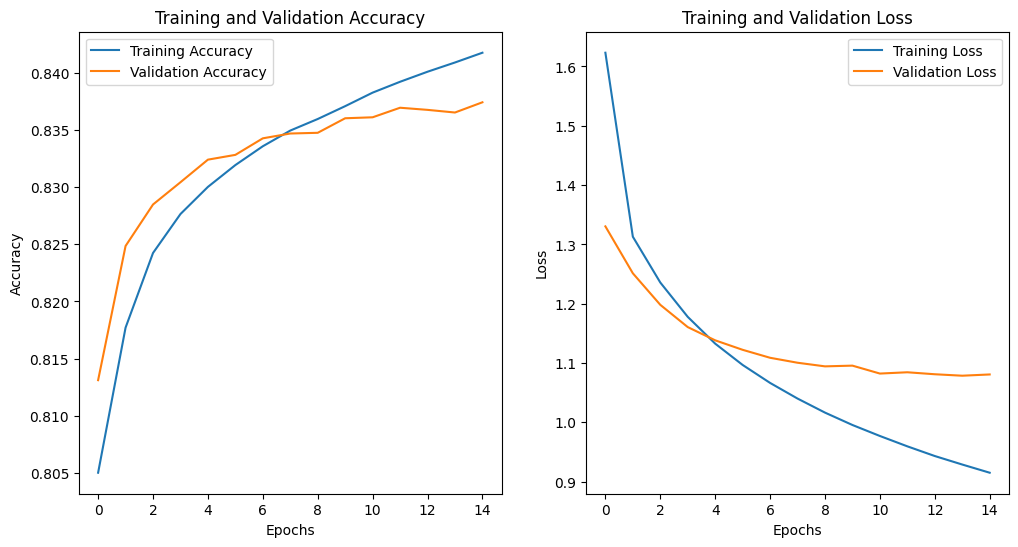

In [20]:
# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [21]:
import tensorflow as tf

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded, verbose=0, batch_size=8)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on test set
predictions = model.predict(X_test_padded[:50], batch_size=8)

# Convert predictions back to text
predicted_sentences = []
for pred in predictions:
    predicted_indices = np.argmax(pred, axis=-1)
    predicted_sentence = ' '.join(
        [tokenizer.index_word.get(idx, '') for idx in predicted_indices if idx != 0]
    )
    predicted_sentences.append(predicted_sentence)


Test Loss: 1.0367, Test Accuracy: 0.8394
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [22]:

smooth = SmoothingFunction()
bleu_scores = [
    sentence_bleu(
        [y_test[:50].iloc[i].split()],  # Reference
        predicted_sentences[i].split(),  # Prediction
        smoothing_function=smooth.method1
    )
    for i in range(len(y_test[:50]))
]

# Average BLEU score
average_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score on Test Set: {average_bleu:.4f}")

for i in range(10,20):  # Show 5 samples
    input_sentence = X_test.iloc[i]
    reference_sentence = y_test.iloc[i]
    predicted_sentence = predicted_sentences[i]

    # Calculate BLEU score
    reference_tokens = [reference_sentence.split()]
    predicted_tokens = predicted_sentence.split()
    bleu_score = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smooth.method1)
    bleu_scores.append(bleu_score)

    # Display results
    print(f"Input: {input_sentence}")
    print(f"Reference: {reference_sentence}")
    print(f"Prediction: {predicted_sentence}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 50)

# Calculate and print average BLEU score for the displayed samples
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score for Displayed Samples: {average_bleu:.4f}")

Average BLEU Score on Test Set: 0.0763
Input: Yang merupakan 10 film terbaik 2016 & mengapa?
Reference: Apa top 10 film Hindi 2016?
Prediction: apa merupakan terbaik film terbaik
BLEU Score: 0.0440
--------------------------------------------------
Input: Jika Universe Expands dan Vacuum Energy dibuat dengannya (tanpa batas), apakah ada energi potensial yang tak terbatas / energi vakum tak terbatas yang dapat dibuat?
Reference: Jika energi dibuat dan tidak dilestarikan dalam alam semesta yang berkembang (yang mengembang tanpa batas) dapatkah energi tak terbatas diciptakan?
Prediction: jika energi gelap dibuat dibuat dibuat dibuat dibuat energi
BLEU Score: 0.0093
--------------------------------------------------
Input: Topik mana di Quora yang paling populer dan memiliki pengikut terbanyak?
Reference: Apa 50 topik dengan pengikut paling banyak di Quora?
Prediction: apa mana di di quora paling di
BLEU Score: 0.0295
--------------------------------------------------
Input: Apa itu Kriter

batasssssssssssssssssssssssssss

In [ ]:
from tensorflow.keras.models import load_model

# Memuat model dari file checkpoint
model = load_model('/content/drive/MyDrive/best_model_LSTM_0.8361.keras')

In [ ]:
def predict_paraphrase(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')
    predictions = model.predict(X_test_padded, batch_size=8)
    predicted_tokens = np.argmax(prediction, axis=-1)[0]
    predicted_text = tokenizer.sequences_to_texts([predicted_tokens])[0]
    return predicted_text

In [ ]:
# Preprocessing input
input_padded = "bagaimana cara mempelajari jaringan komputer"  # Ganti dengan kalimat yang lebih sederhana

input_seq = tokenizer.texts_to_sequences([input_padded])
input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

# Menghasilkan prediksi
predicted = model.predict(input_padded)

# Mengecek output prediksi
# print("Predicted probabilities:", predicted)

# Ambil kata dengan probabilitas tertinggi untuk setiap langkah
predicted_indices = np.argmax(predicted, axis=-1)

# Konversi indeks ke kata
predicted_words = [tokenizer.index_word.get(index, '') for index in predicted_indices[0]]

# Gabungkan kata-kata menjadi satu kalimat
parafrase = ' '.join(predicted_words).replace('  ', ' ').strip()

print("Parafrase:", parafrase)

In [ ]:
import nltk
# nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu  # Import BLEU score

# Kalimat referensi yang benar (misalnya, kalimat asli atau kalimat parafrase yang diinginkan)
reference = "bagaimana cara belajar jaringan komputer"  # Ganti dengan kalimat referensi yang sesuai

# Menghitung BLEU score
reference_tokens = reference.split()  # Tokenisasi kalimat referensi
predicted_tokens = parafrase.split()  # Tokenisasi kalimat hasil prediksi

# Menghitung BLEU score
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

print("BLEU Score:", bleu_score)

In [ ]:
# Menyimpan model
# model.save('paraphrase_LSTM_model.h5')


In [ ]:
datatest = {
    'question': [
        "Apa manfaat yoga untuk kesehatan?",
        "Bagaimana cara membuat kue cokelat?",
        "Mengapa penting untuk tidur cukup?",
        "Apa perbedaan antara data dan informasi?",
        "Apa yang harus dilakukan agar lebih produktif?",
        "Bagaimana cara menjaga kesehatan jantung?",
        "Apa saja manfaat belajar bahasa asing?",
        "Mengapa olahraga penting bagi tubuh?",
        "Apa itu ekonomi digital?",
        "Apa yang dimaksud dengan kecerdasan buatan?"
    ],
    'reference': [
        "Apa saja manfaat yoga bagi kesehatan tubuh?",
        "Apa langkah-langkah untuk membuat kue cokelat?",
        "Mengapa tidur yang cukup sangat penting untuk tubuh?",
        "Apa yang membedakan antara data dan informasi?",
        "Apa saja tips agar lebih produktif dalam bekerja?",
        "Apa yang harus dilakukan untuk menjaga kesehatan jantung?",
        "Apa keuntungan yang didapatkan dari belajar bahasa asing?",
        "Apa alasan olahraga sangat penting untuk kesehatan tubuh?",
        "Bagaimana ekonomi digital memengaruhi kehidupan kita?",
        "Apa itu AI dan bagaimana cara kerjanya?"
    ]
}

In [ ]:
# Membuat DataFrame
df2 = pd.DataFrame(datatest)

# Preprocessing data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df2['question'].tolist() + df2['reference'].tolist())  # Gabungkan kedua kolom untuk pelatihan tokenizer
max_length = max(df2['question'].apply(lambda x: len(x.split())).max(),
                 df2['reference'].apply(lambda x: len(x.split())).max())

# Tokenisasi input dan referensi
question_seq = tokenizer.texts_to_sequences(df2['question'].tolist())
reference_seq = tokenizer.texts_to_sequences(df2['reference'].tolist())

question_padded = pad_sequences(question_seq, maxlen=max_length, padding='post')
reference_padded = pad_sequences(reference_seq, maxlen=max_length, padding='post')

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('paraphrase_LSTM_model.h5')#'best_model_LSTM_0.9040.keras')

In [ ]:
# Fungsi untuk memprediksi parafrase
def predict_paraphrase(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')
    prediction = model.predict(input_padded)

    # Ambil prediksi dengan nilai tertinggi (berdasarkan probabilitas)
    predicted_tokens = np.argmax(prediction, axis=-1)[0]

    # Mengonversi kembali token menjadi teks
    predicted_text = tokenizer.sequences_to_texts([predicted_tokens])[0]
    return predicted_text

# Menggunakan SmoothingFunction untuk BLEU score
smoothing = SmoothingFunction().method1

# Melakukan prediksi dan menghitung BLEU score untuk setiap kalimat dalam DataFrame
for i in range(len(df2)):
    input_question = df2['question'][i]
    reference_paraphrase = df2['reference'][i]

    # Prediksi parafrase
    predicted_paraphrase = predict_paraphrase(input_question)

    # Tokenisasi referensi dan hasil prediksi untuk BLEU score
    reference_tokens = tokenizer.texts_to_sequences([reference_paraphrase])[0]
    predicted_tokens = tokenizer.texts_to_sequences([predicted_paraphrase])[0]

    # Menghitung BLEU score
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens, smoothing_function=smoothing)

    # Menampilkan hasil
    print(f"Pertanyaan: {input_question}")
    print(f"Parafrase yang diprediksi: {predicted_paraphrase}")
    print(f"Referensi: {reference_paraphrase}")
    print(f"BLEU score: {bleu_score:.4f}")
    print("-" * 50)

In [ ]:
# Preprocessing input
input_padded = "sehat itu mahal"  # Ganti dengan kalimat yang lebih sederhana

input_seq = tokenizer.texts_to_sequences([input_padded])
input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

# Menghasilkan prediksi
predicted = model.predict(input_padded)

# Mengecek output prediksi
# print("Predicted probabilities:", predicted)

# Ambil kata dengan probabilitas tertinggi untuk setiap langkah
predicted_indices = np.argmax(predicted, axis=-1)

# Konversi indeks ke kata
predicted_words = [tokenizer.index_word.get(index, '') for index in predicted_indices[0]]

# Gabungkan kata-kata menjadi satu kalimat
parafrase = ' '.join(predicted_words).replace('  ', ' ').strip()

print("Parafrase:", parafrase)

In [ ]:
# Kalimat referensi yang benar (misalnya, kalimat asli atau kalimat parafrase yang diinginkan)
reference = "kesehatan itu mahal"  # Ganti dengan kalimat referensi yang sesuai

# Menghitung BLEU score
reference_tokens = reference.split()  # Tokenisasi kalimat referensi
predicted_tokens = parafrase.split()  # Tokenisasi kalimat hasil prediksi

# Menghitung BLEU score
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

print("BLEU Score:", bleu_score)

In [ ]:
# Preprocessing input
input_padded = "kenapa kita harus belajar"  # Ganti dengan kalimat yang lebih sederhana

input_seq = tokenizer.texts_to_sequences([input_padded])
input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

# Menghasilkan prediksi
predicted = model.predict(input_padded)

# Mengecek output prediksi
# print("Predicted probabilities:", predicted)

# Ambil kata dengan probabilitas tertinggi untuk setiap langkah
predicted_indices = np.argmax(predicted, axis=-1)

# Konversi indeks ke kata
predicted_words = [tokenizer.index_word.get(index, '') for index in predicted_indices[0]]

# Gabungkan kata-kata menjadi satu kalimat
parafrase = ' '.join(predicted_words).replace('  ', ' ').strip()

print("Parafrase:", parafrase)

In [ ]:
# Kalimat referensi yang benar (misalnya, kalimat asli atau kalimat parafrase yang diinginkan)
reference = "mengapa kita harus belajar"  # Ganti dengan kalimat referensi yang sesuai

# Menghitung BLEU score
reference_tokens = reference.split()  # Tokenisasi kalimat referensi
predicted_tokens = parafrase.split()  # Tokenisasi kalimat hasil prediksi

# Menghitung BLEU score
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

print("BLEU Score:", bleu_score)

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath='best_model_2_LSTM_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(X_padded, y_padded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])
model.summary()

In [ ]:
# Melakukan prediksi dan menghitung BLEU score untuk setiap kalimat dalam DataFrame
for i in range(len(df2)):
    input_question = df2['question'][i]
    reference_paraphrase = df2['reference'][i]

    # Prediksi parafrase
    predicted_paraphrase = predict_paraphrase(input_question)

    # Tokenisasi referensi dan hasil prediksi untuk BLEU score
    reference_tokens = tokenizer.texts_to_sequences([reference_paraphrase])[0]
    predicted_tokens = tokenizer.texts_to_sequences([predicted_paraphrase])[0]

    # Menghitung BLEU score
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens, smoothing_function=smoothing)

    # Menampilkan hasil
    print(f"Pertanyaan: {input_question}")
    print(f"Parafrase yang diprediksi: {predicted_paraphrase}")
    print(f"Referensi: {reference_paraphrase}")
    print(f"BLEU score: {bleu_score:.4f}")
    print("-" * 50)